'Project code for tools'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('CompleteDataset_modified.csv')

Best_Squard formation

In [95]:
df = pd.read_csv('CompleteDataset.csv')
#Common formations are listed below
#4-3-3:a formation that consists of 4 defenders, 3 midfielders and 3 forwards
squad_433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'LW', 'CF', 'RW']
#4-2-4: a formation that consists of 4 defenders, 2 midfielders and 4 forwards.
squard_424 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'RM', 'CF', 'LW', 'CF', 'RW']
#4-4-2: a formation that consists of 4 defenders, 4 midfielders and 2 forwards
squard_442 = ['GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CF', 'CF']
#3-4-3: a formation that consists of 3 defenders, 4 midfielders and 3 forwards
squard_343 = ['GK', 'CB', 'CB', 'CB', 'RM', 'LM', 'CM', 'CM', 'LW', 'CF', 'RW']
#4-5-1: a formation that consists of 3 defenders, 4 midfielders and 3 forwards
squard_451 = ['GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CDM', 'CF']


#Select a set of identical formation type
s = ''
for i in df.index:
    s += ' '+df.loc[i,'Preferred Positions']
l = s.split(' ')

#find all formation type in the dataset
#formation_type = ['CB', 'RM', 'LM', 'CM', 'CF', 'LW', 'LWB', 'ST', 'RWB', 'LB', 'CDM', 'RB', 'RW', 'GK', 'CAM']
formation_choice = {'433':('GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'LW', 'CF', 'RW'),
                    '424':('GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'RM', 'CF', 'LW', 'CF', 'RW'),
                    '442':('GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CF', 'CF'),
                    '343':('GK', 'CB', 'CB', 'CB', 'RM', 'LM', 'CM', 'CM', 'LW', 'CF', 'RW'),
                    '451':('GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CDM', 'CF')}

def formation_choose():
    n = input("Choose the formation you want to know")
    if n in formation_choice.keys():
        choice = list(formation_choice[n])
        return choice
    else:
        print("Sorry, this formation doesn't exist")

choice=formation_choose()  
def formation_matrix(df,choice):
    for i in choice:
        formation_score = []
        for j in df.index:
            if i in df.loc[j,'Preferred Positions']:
                formation_score.append((df.loc[j,'Preferred Positions'],df.loc[j,'Name'],df.loc[j,'Overall'],df.loc[j,'Nationality']))
        first = sorted(formation_score, key=lambda x:x[2],reverse = True)[0]
        print(first)

formation_score = formation_matrix(df,choice) 

/Users/shipeifeng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Choose the formation you want to know433
('GK ', 'M. Neuer', 92, 'Germany')
('LB ', 'Marcelo', 87, 'Brazil')
('CB ', 'Sergio Ramos', 90, 'Spain')
('CB ', 'Sergio Ramos', 90, 'Spain')
('LB RB CB ', 'Azpilicueta', 85, 'Spain')
('RM LW ST LM ', 'A. Sánchez', 89, 'Chile')
('CDM CM ', 'T. Kroos', 90, 'Germany')
('RM CM CAM ', 'K. De Bruyne', 89, 'Belgium')
('ST LW ', 'Cristiano Ronaldo', 94, 'Portugal')
('ST CAM RW CF ', 'T. Müller', 86, 'Germany')
('RW ', 'L. Messi', 93, 'Argentina')


Best Nationality Squard

In [94]:
df = pd.read_csv('CompleteDataset.csv')
c = ''
for n in df.index:
    c += ' '+df.loc[n,'Nationality']
l1 = c.split(' ')

country_list = list(set(l1))

def country_choose():
    x = input("Which country you want to know\n")
    if x in country_list:
        return x
    else:
        print("Sorry, the country you choose is not included")

x = country_choose()

df_country = df[df['Nationality'] == x]
country_formation_score = formation_matrix(df_country,choice) 


/Users/shipeifeng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Which country you want to know
Brazil
('GK ', 'Ederson', 83, 'Brazil')
('LB ', 'Marcelo', 87, 'Brazil')
('CB ', 'Thiago Silva', 88, 'Brazil')
('CB ', 'Thiago Silva', 88, 'Brazil')
('RB ', 'Dani Alves', 84, 'Brazil')
('LM LB ', 'Alex Sandro', 86, 'Brazil')
('CDM ', 'Casemiro', 85, 'Brazil')
('CAM RM RW ', 'Willian', 84, 'Brazil')
('LW ', 'Neymar', 92, 'Brazil')
('CAM CF ST ', 'Roberto Firmino', 83, 'Brazil')
('CAM RM RW ', 'Willian', 84, 'Brazil')


### comparing player

In [18]:
def player_compare():
    import matplotlib.pyplot as plt
    from matplotlib import gridspec 
    import pandas as pd
    import numpy as np
    df = pd.read_csv('CompleteDataset_modified.csv')
    
    names = input("Enter two players' names you want to compare(seperated by ','): ")
    names = names.split(',')
    
    for i in names:
        if not i in df.Name.values:
            return "Sorry,the player %s doesn't exit."%i
        
    df[['Value']] = df[['Value']].astype(int)
    name1 = names[0]
    name2 = names[1]
    
    df1 = df[(df['Name'] == name1)]
    value1 = df1['Value'].values[0]
    df1 = df1[['Potential','Overall','Age']]
    df1.columns = [['Potential (100)','Overall (100)','Age']]
    df1 = df1.T
    df1.reset_index(level=0, inplace=True)
    df1.columns = ['property','data']
    x = df1['property']
    y1 = df1['data'].apply(lambda x : -x)
    
    df2 = df[(df['Name'] == name2)]
    value2 = df2['Value'].values[0]
    df2 = df2[['Potential','Overall','Age']]
    df2.columns = [['Potential (100)','Overall (100)','Age']]
    df2 = df2.T
    df2.reset_index(level=0, inplace=True)
    df2.columns = ['property','data']
    y2 = df2['data']

    fig = plt.figure(figsize=(16,12))
    fig.suptitle('----< %s  VS.  %s >----'%(name1,name2),fontsize = 20) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 6]) 
    plt.subplot(gs[0])
    plt.barh(x, y1)
    plt.barh(x, y2)

    plt.xticks(())
    plt.xlabel('%s -Value(€):%d                %s -Value(€):%d'%(name1,value1,name2,value2),labelpad = 15, fontsize = 'xx-large')
    for x, y1, y2 in zip(x, y1, y2):
    #ha: horizontal alignmen
    #va: vertical alignment
        plt.text(y1, x, '%d' % -y1, ha='right', va = 'center', fontsize = 'x-large')  
        plt.text(y2, x, '%d' % y2 , ha='left',va = 'center', fontsize = 'x-large')
    
    cols = ['Acceleration','Dribbling','Long passing','Shot power','Strength','Marking']

    # 把圆形进行六等分
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # 初始化一个极坐标图像
    plt.subplot(gs[1])
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    ax = fig.add_subplot(212,polar=True)
    
    df1 = df[(df['Name'] == name1)]
    stats = df1[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='orange', label='%s'%name1)
    ax.fill(angles, stats, c='orange', alpha=0.35)

    df2 = df[(df['Name'] == name2)]
    stats = df2[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='blue', label='%s'%name2)
    ax.fill(angles, stats, c='blue', alpha=0.35)

    # add lables
    ax.legend(loc=[0.25, 1.15], fontsize=16)
    ax.set_ylim(0,100)
#     ax.set_yticklabels([])
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)


Enter two players' names you want to compare(seperated by ','): Cristiano Ronaldo,Neymar


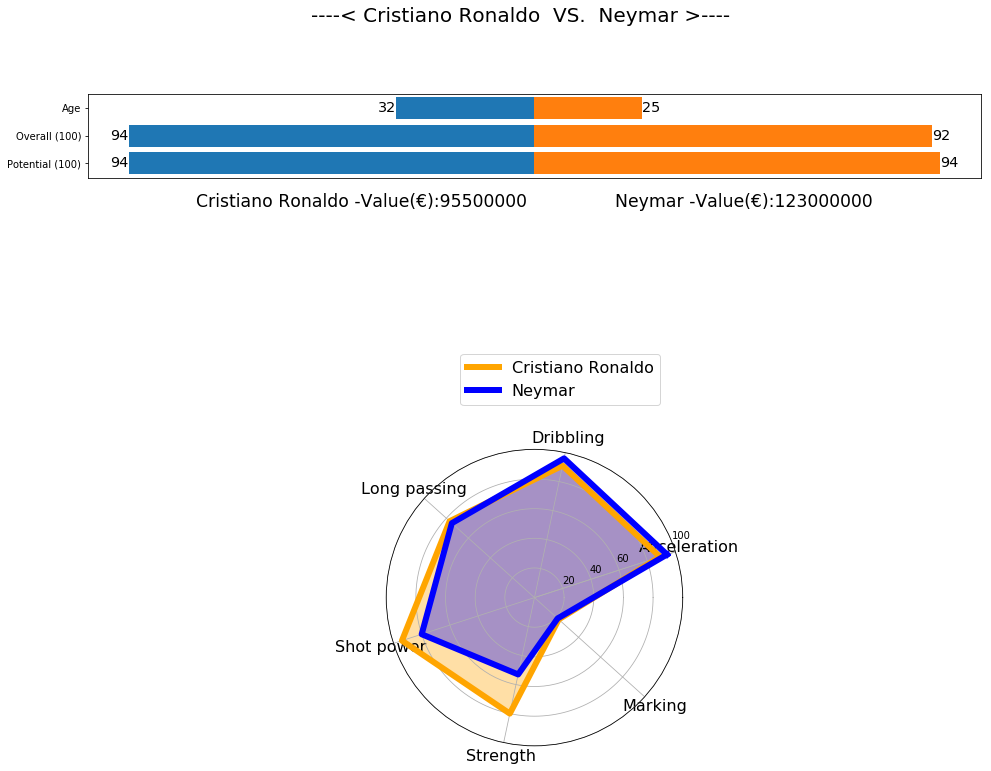

In [20]:
player_compare()

### Comparing club

In [21]:
def club_compare():
    import matplotlib.pyplot as plt
    from matplotlib import gridspec 
    import pandas as pd
    import numpy as np
    df = pd.read_csv('CompleteDataset_modified.csv')
    
    names = input("Enter two clubs' names you want to compare(seperated by ','): ")
    names = names.split(',')
    
    # only for check
    for i in names:
        if not i in df.Club.values:
            return "Sorry,the club %s doesn't exit."%i
    
    df[['Value']] = df[['Value']].astype(int)
    df = df.groupby('Club').mean()
    df.reset_index(level=0, inplace=True)
    name1 = names[0]
    name2 = names[1]
    
    df1 = df[(df['Club'] == name1)]
    value1 = df1['Value'].values[0]
    df1 = df1[['Potential','Overall','Age']]
    df1.columns = [['Potential (100)','Overall (100)','Age']]
    df1 = df1.T
    df1.reset_index(level=0, inplace=True)
    df1.columns = ['property','data']
    x = df1['property']
    y1 = df1['data'].apply(lambda x : -x)
    
    df2 = df[(df['Club'] == name2)]
    value2 = df2['Value'].values[0]
    df2 = df2[['Potential','Overall','Age']]
    df2.columns = [['avg. Potential (100)','avg. Overall (100)','avg. Age']]
    df2 = df2.T
    df2.reset_index(level=0, inplace=True)
    df2.columns = ['property','data']
    y2 = df2['data']

    fig = plt.figure(figsize=(16,12))
    fig.suptitle('----< %s  VS.  %s >----'%(name1,name2),fontsize = 20) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 6]) 
    plt.subplot(gs[0])
    plt.barh(x, y1)
    plt.barh(x, y2)

    plt.xticks(())
    plt.xlabel('%s -Value(€):%d                %s -Value(€):%d'%(name1,value1,name2,value2),labelpad = 15, fontsize = 'xx-large')
    for x, y1, y2 in zip(x, y1, y2):
    #ha: horizontal alignmen
    #va: vertical alignment
        plt.text(y1, x, '%d' % -y1, ha='right', va = 'center', fontsize = 'x-large')  
        plt.text(y2, x, '%d' % y2 , ha='left',va = 'center', fontsize = 'x-large')
    
    cols = ['Aggression','Ball control','Free kick accuracy','Heading accuracy','Finishing','Penalties']

    # 把圆形进行六等分
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # 初始化一个极坐标图像
    plt.subplot(gs[1])
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    ax = fig.add_subplot(212,polar=True)
    
    df1 = df[(df['Club'] == name1)]
    stats = df1[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='orange', label='%s'%name1)
    ax.fill(angles, stats, c='orange', alpha=0.35)

    df2 = df[(df['Club'] == name2)]
    stats = df2[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='blue', label='%s'%name2)
    ax.fill(angles, stats, c='blue', alpha=0.35)

    # 添加图例
    ax.legend(loc=[0.25, 1.15], fontsize=16)
    ax.set_ylim(0,100)
#     ax.set_yticklabels([])
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)

   
    # to show different game result when two club choose different team's formation--not done yet
#     game_data = list()
#     formation_choice = {'433':('GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW'),
#                         '424':('GK', 'LB', 'CB', 'CB', 'RB','LM','RM','CF','LW','ST','RW')}
#     for i in formation_choice.keys():
#         for j in formation_choice.keys():
#             game_data.append(formation_matrix(i),)  
            
            
#     !pip install prettytable
#     from prettytable import PrettyTable
#     table = PrettyTable([name1,'Formation','Predicted result','Formation',name2])
#     for i in game_data:
#         table.add_row(list(i))
#     print(table)

Enter two clubs' names you want to compare(seperated by ','): Paris Saint-Germain,FC Barcelona


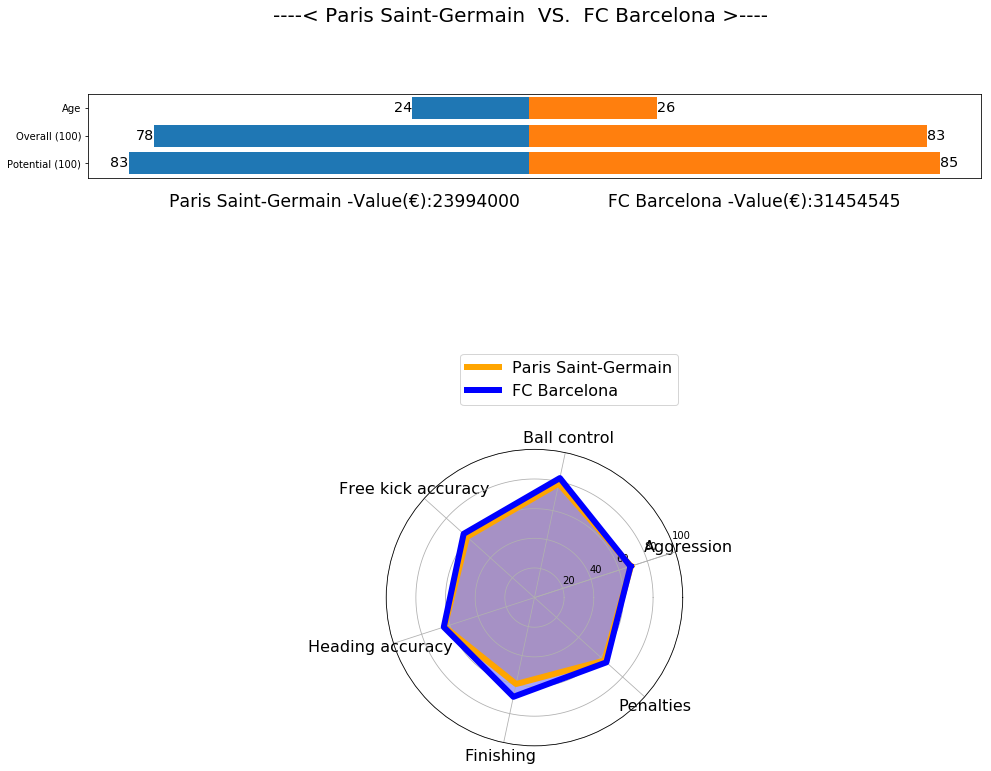

In [22]:
club_compare()

### Age and Score Analysis

In [4]:
def Age_Score():
    n = input("Enter the player's name you want to know")
    if n in df.Name.values:
        index = list(df['Name']).index(n)
    else:
        return f"Sorry,the player {n} doesn't exit."

    # Save all non-repeating ages in the database as a list
    Age = list(set(df['Age']))

    # Calculate the mean of overall scores of players at each age
    gr_Overall = df['Overall'].groupby(df['Age'])
    Overall_mean = gr_Overall.mean()
    gr_Potential = df['Potential'].groupby(df['Age'])
    Potential_mean = gr_Potential.mean()

    x = df.loc[index,'Age']
    y_o = df.loc[index,'Overall']
    y_p = df.loc[index,'Potential']

    # Plot the relationship of age and scores
    plt.figure(figsize=(10,6))
    plt.plot(x,y_o,'b*',label='Player Overall')
    plt.plot(x,y_p,'r*',label='Player Potential')
    plt.plot(Age,Overall_mean,label='Total Overall')
    plt.plot(Age,Potential_mean,label='Total Potential')
    plt.xlabel('Age')
    plt.ylabel('Score')
    plt.legend(loc='upper right')
    plt.title('Relationship between Age and Score')

Enter the player's name you want to knowNeymar


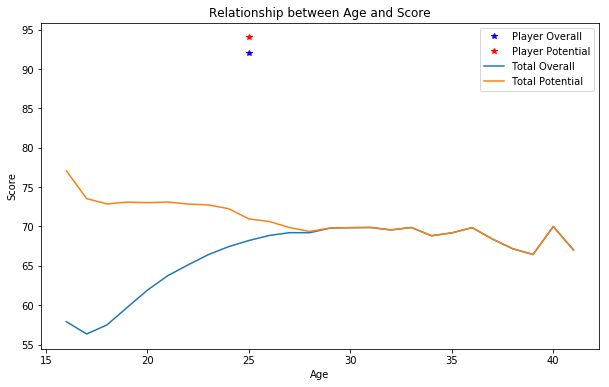

In [5]:
Age_Score()

In [14]:
df.dropna(inplace = True)

In [16]:
import re
for i in l:
    for j in df.index:
        x = df.loc[j,i]
        try:
            int(x)
        except ValueError:
            pattern1 = r'^(?P<num1>\d+)+(?P<num2>\d+)'
            flags = (
                re.IGNORECASE |  # Match against upper and lower case with one case
                re.VERBOSE  # Match with comments
                )
            match1 = re.match(pattern1, x, flags=flags)
            pattern2 = r'^(?P<num1>\d+)-(?P<num2>\d+)'
            match2 = re.match(pattern2, x, flags=flags)
            if match1:
                num1 = match1.group('num1') 
                num2 = match1.group('num2') 
                df.loc[j,i] = int(num1)+int(num2)
            if match2:
                num1 = match1.group('num1') 
                num2 = match1.group('num2') 
                df.loc[j,i] = int(num1)-int(num2)

In [17]:
df.to_csv('CompleteDataset_modify.csv', encoding='utf-8')
d = pd.read_csv('CompleteDataset_modify.csv')
d[l]

,Age,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,32,2228,89,63,89,63,93,95,85,81,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,30,2154,92,48,90,95,95,96,77,89,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,25,2100,94,56,96,82,95,92,75,81,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,30,2291,88,78,86,60,91,83,77,86,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,28,2143,79,80,78,80,89,87,62,77,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0
5,26,2096,93,54,93,91,92,87,80,82,...,59.0,47.0,81.0,61.0,87.0,87.0,82.0,88.0,64.0,82.0
6,27,2165,60,60,71,69,89,85,85,85,...,76.0,72.0,87.0,82.0,81.0,81.0,77.0,80.0,78.0,77.0
7,29,1961,78,50,75,69,85,86,68,74,...,51.0,46.0,71.0,52.0,84.0,79.0,87.0,82.0,55.0,87.0
8,31,2153,75,84,79,60,84,80,66,73,...,84.0,87.0,74.0,83.0,70.0,71.0,72.0,69.0,81.0,72.0
9,26,2162,76,68,80,75,87,84,90,83,...,66.0,57.0,84.0,70.0,85.0,85.0,81.0,85.0,71.0,81.0


In [2]:
import re
df = pd.read_csv('CompleteDataset_modify.csv')
# Clean data of column 'Value'
for j in df.index:
    x = df.loc[j,'Value']
    if type(x) == str:
        pattern1 = r'^(?P<currency>\D+)(?P<value>\d*\.?\d+)(?P<unit>M)'
        flags = (
            re.IGNORECASE |  # Match against upper and lower case with one case
            re.VERBOSE  # Match with comments
            )
        match1 = re.match(pattern1, x, flags=flags)
        pattern2 = r'^(?P<currency>\D+)(?P<value>\d*\.?\d+)(?P<unit>K)'
        match2 = re.match(pattern2, x, flags=flags)
        pattern3 = r'^(?P<currency>\D+)(?P<value>\d+)$'
        match3 = re.match(pattern3, x, flags=flags)
        if match1:
            value1 = match1.group('value')
            df.loc[j,'Value'] = float(value1) * 1000000
        if match2:
            value2 = match2.group('value')
            df.loc[j,'Value'] = float(value2) * 1000
        if match3:
            value3 = match3.group('value')
            df.loc[j,'Value'] = int(value3)

In [4]:
df.to_csv('CompleteDataset_modified.csv', encoding='utf-8')


0         95500000.0
1        105000000.0
2        123000000.0
3         97000000.0
4         92000000.0
5         90500000.0
6         79000000.0
7         77000000.0
8         52000000.0
9         83000000.0
10        67500000.0
11        57000000.0
12        69500000.0
13        66500000.0
14        38000000.0
15        79000000.0
16        75000000.0
17        70500000.0
18        61000000.0
19        44000000.0
20        48000000.0
21        40000000.0
22        48000000.0
23        60000000.0
24        34000000.0
25        27000000.0
26        36000000.0
27        52500000.0
28        64500000.0
29        66500000.0
            ...     
15716        30000.0
15717        70000.0
15718        60000.0
15719        60000.0
15720        60000.0
15721        60000.0
15722        60000.0
15723        50000.0
15724        50000.0
15725        40000.0
15726        60000.0
15727        70000.0
15728        60000.0
15729        50000.0
15730        50000.0
15731        60000.0
15732        

In [3]:
d = pd.read_csv('CompleteDataset_modified.csv')

In [4]:
def GropFunc(ind,col,data,position):
    if position in data.loc[ind,col]:
        return position
    else:
        return False

In [5]:
l = ['RB','LM','RM','CF','CDM','ST','LW','CM','RWB','CB','LWB','RW','CAM','LB']
variables =  ['Age',
 'Special',
 'Acceleration',
 'Aggression',
 'Agility',
 'Balance',
 'Ball control',
 'Composure',
 'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'GK diving',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes',
 'Heading accuracy',
 'Interceptions',
 'Jumping',
 'Long passing',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Reactions',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Stamina',
 'Standing tackle',
 'Strength',
 'Vision',
 'Volleys']

In [7]:
def groupby_position(data,positions,variables):
    data_ = pd.DataFrame(np.zeros(len(variables)))
    result = data_.transpose()
    result.columns = variables
    for i in positions:
        grouped = d.groupby(lambda x:GropFunc(x,'Preferred Positions',data,i))
        result.loc[i]=grouped.mean()[variables].loc[i]
    return result
data = groupby_position(d,l,variables)

[ 86.87  97.84  99.07  99.85  99.93  99.97  99.99 100.   100.01 100.01
 100.01 100.01 100.01 100.01 100.01]


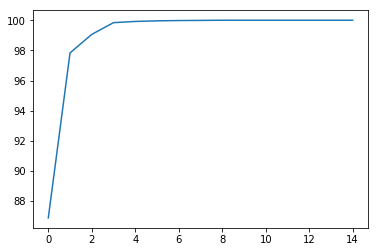

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline
#转换成数字型数组
X=data.values
#Scaling the values
X = scale(X)
pca = PCA(n_components=31)
pca.fit(X)
#每一个PC说明的方差数量
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)

In [22]:
def pca(data_pca,n):
    meanVal=np.mean(data_pca,axis=0)
    newData=data_pca-meanVal
    covMat=np.cov(newData,rowvar=0)
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    eigValIndice=np.argsort(eigVals) 
    n_eigValIndice=eigValIndice[-1:-(n+1):-1] 
    n_eigVect=eigVects[:,n_eigValIndice]
    lowDDataMat=newData.values*n_eigVect
    return n_eigVect
result = pd.DataFrame(pca(data.iloc[1:],4))
result.index = variables
result[result>0.1]

,0,1,2,3
Age,NaN,NaN,NaN,NaN
Special,(0.9602753848918286+0j),NaN,NaN,NaN
Acceleration,NaN,NaN,(0.42392860515163333+0j),NaN
Aggression,NaN,NaN,NaN,NaN
Agility,NaN,NaN,(0.24750270760218368+0j),NaN
Balance,NaN,NaN,(0.18366684872131345+0j),(0.14010462084140018+0j)
Ball control,NaN,NaN,NaN,NaN
Composure,NaN,NaN,NaN,NaN
Crossing,NaN,NaN,(0.3746740129755593+0j),(0.16392493294518265+0j)
Curve,NaN,(0.10520813900977381+0j),NaN,(0.18595273756643152+0j)


In [23]:
data_visulization = result.astype(float)

/Users/yahanhu/anaconda3/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:730: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [25]:
def Change_dataframe_to_cloud_data(data):
    dics = []
    for i in data.columns:
        dic = dict()
        for j in data.index:
            dic[j] = data.loc[j,i]
        dics.append(dic)
    return dics
dics = Change_dataframe_to_cloud_data(data_visulization)

In [28]:
# #Set up side by side clouds
# COL_NUM = 2
# ROW_NUM = 2
# fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

def plot():
    import wordcloud
    cloud = wordcloud.WordCloud(background_color='white',width=1200,height=1000,max_words=20)
    frequencies = dics[0]
    cloud.fit_words(frequencies)
    plt.figure(figsize=(15,15))
    plt.imshow(cloud) # 在坐标轴上显示图像
    plt.axis("off") # 去除图像坐标轴
    plt.show()

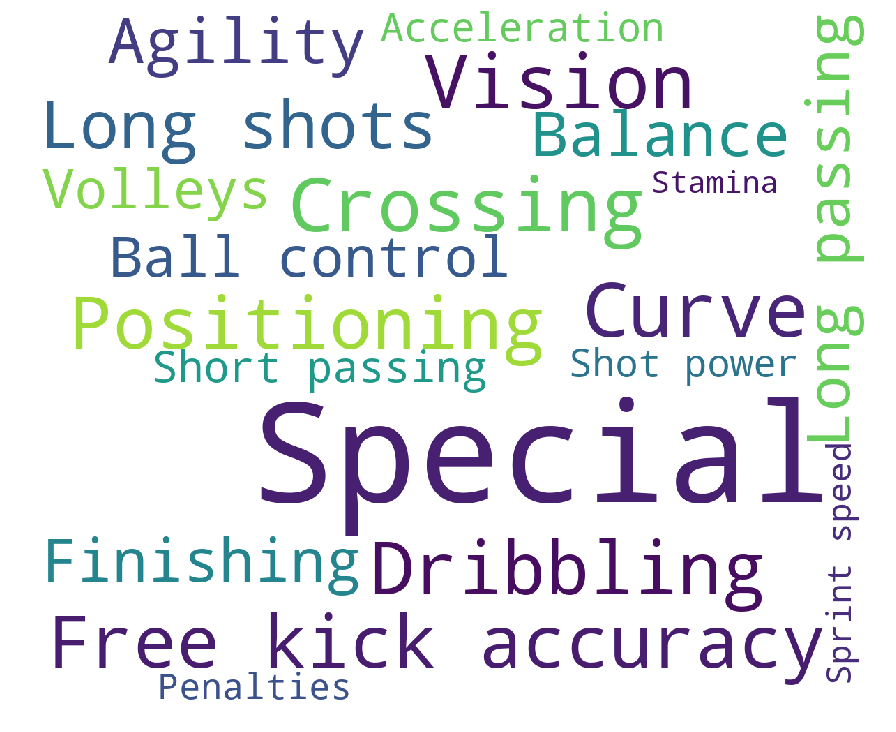

In [29]:
plot()

d:\python\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


-0.0015399321074721231
[0.64628254 0.23364857]
[-0.63130905 -1.60367838 -0.74131082 ...  0.28311831 -0.15688878
  1.29284193]


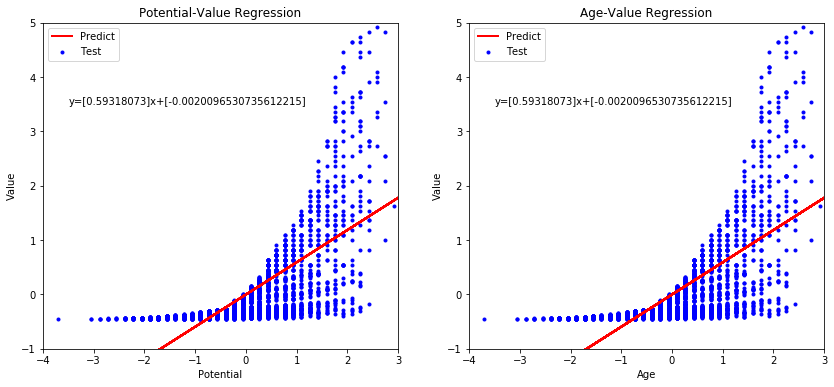

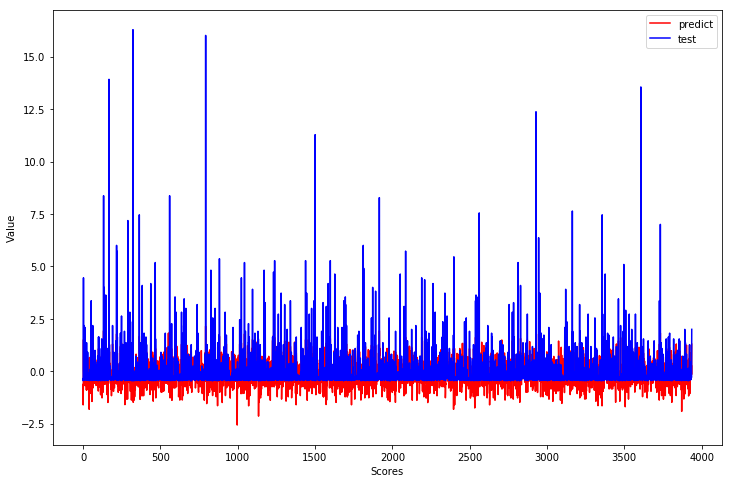

MSE: 0.7828691259064554


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import metrics
X2 = df.Potential
X3 = df.Age
X = pd.concat([X2,X3],axis=1)
y = df.Value
Z = pd.concat([X,y],axis=1)
Z_scaled = scale(Z)
Z_scaled
P = Z_scaled[:,0]
A = Z_scaled[:,1]
V = Z_scaled[:,2]
PA = np.c_[P,A]
P_train,P_test, V_train, V_test = train_test_split(P, V, random_state=1)
A_train,A_test, V_train, V_test = train_test_split(P, V, random_state=1)
PA_train,PA_test, V_train, V_test = train_test_split(PA, V, random_state=1)
rg = LinearRegression()
model = rg.fit(PA_train,V_train)
print (rg.intercept_)
print (rg.coef_)
V_pred = rg.predict(PA_test)
print (V_pred)
fig = plt.figure(figsize=(14, 6))

p1 = fig.add_subplot(121)
rg1 = LinearRegression()
model1 = rg1.fit(P_train.reshape(-1, 1),V_train)
k1 = rg1.coef_
b1 = rg1.intercept_
plt.scatter(P_test, V_test, color='blue',marker='.',label='Test')
plt.plot(P_test, rg1.predict(P_test.reshape(-1,1)), color='red', linewidth=2,label='Predict')
plt.xlim((-4, 3))
plt.ylim((-1, 5))
plt.xlabel('Potential')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.text(-3.5, 3.5, f'y={k1}x+[{b1}]',withdash=2)
plt.title('Potential-Value Regression')

p2 = fig.add_subplot(122)
rg2 = LinearRegression()
model2 = rg2.fit(A_train.reshape(-1, 1),V_train)
k2 = rg1.coef_
b2 = rg1.intercept_
plt.scatter(A_test, V_test, color='blue',marker='.',label='Test')
plt.plot(A_test, rg2.predict(P_test.reshape(-1,1)), color='red', linewidth=2,label='Predict')
plt.xlim((-4, 3))
plt.ylim((-1, 5))
plt.xlabel('Age')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.text(-3.5, 3.5, f'y={k2}x+[{b2}]',withdash=2)
plt.title('Age-Value Regression')

plt.figure(figsize=(12,8))
plt.plot(range(len(V_pred)),V_pred,'r',label="predict")
plt.plot(range(len(V_pred)),V_test,'b',label="test")
plt.legend(loc="upper right") 
plt.xlabel("Scores")
plt.ylabel('Value')
plt.show()

sum_mean=0
for i in range(len(V_pred)):
    sum_mean += (V_pred[i] - V_test[i]) ** 2
sum_erro = np.sqrt(sum_mean / 3936)
print ("MSE:",sum_erro)